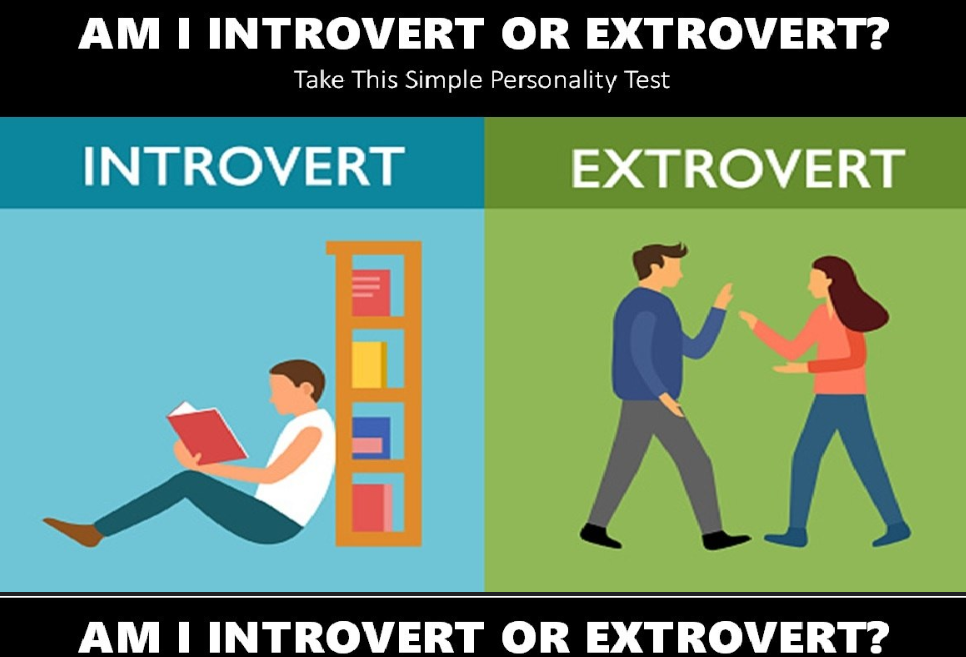

<div style="background-color:#5c2670; padding:20px; border-radius:12px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:28px;">
    🧠 Extrovert vs Introvert: Personality Prediction
  </h1>
</div>

<div style="padding:18px; background-color:#f0f0f0; border-radius:10px; margin-top:12px;">
  <p style="text-align:center; font-size:18px; color:#222; margin:0;">
    In this notebook, we aim to predict whether individuals are <strong>Extroverts</strong> or <strong>Introverts</strong> 
    based on their daily behavior, preferences, and lifestyle patterns.  
    Using the dataset from <strong>Kaggle Playground Series S5E7</strong>, we’ll explore key features, perform 
    data analysis, and apply machine learning models to understand the personality split in a data-driven way.
  </p>
</div>


In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv



<div style="background-color:green; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:24px;">Introduction</h1>
</div>

In this notebook, we will explore the dataset in detail to understand the patterns behind personality types, particularly focusing on the distinction between Introverts and Extroverts. The main steps covered include:

Overview of the dataset: checking shapes, data types, and duplicates

Target variable balance: analyzing the proportion of each class and its impact on validation

Missing value analysis: examining how much data is missing, where it's missing, and possible reasons

Feature distributions: looking at numerical and categorical variables across train, test, and original datasets

Outlier analysis: identifying extreme values using standard deviation and interpreting their importance

Feature-target relationships: studying how input features relate to the target variable

Train-test comparison: checking for data drift using statistical tests




<div style="background-color:green; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:24px;">Key Findings </h1>
</div>

The target variable is moderately imbalanced, with about 74% Extroverts

Missing values are present in 5–10% of the data, and the pattern suggests they are not completely random

There is no significant train-test distribution shift

Two binary features (Stage_fear and Drained_after_socializing) are highly predictive on their own

Extremely high values of Time_spent_Alone (greater than mean + 2 standard deviations) strongly indicate Introverts, with around 94% precision

Numerical behavioral features clearly distinguish between personality types and show only moderate correlation among themselves.




<div style="background-color:green; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:24px;"> Import Libraries </h1>
</div>


In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import warnings, os, gc, sys, math, json, random, itertools

from scipy import stats
from scipy.stats import ks_2samp

# Pretty settings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")
sns.set_palette("crest")
pd.set_option("display.max_columns", 100)

<div style="background-color:#004080; padding:12px 16px; border-radius:10px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:22px;">
    Playground Series S5E7: Personality Prediction - Data Loaded from Kaggle
  </h1>
</div>


In [3]:
# Kaggle paths
TRAIN_PATH = "//kaggle/input/playground-series-s5e7/train.csv"
TEST_PATH  ="/kaggle/input/playground-series-s5e7/test.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

<div style="background-color:#006666; padding:12px 16px; border-radius:10px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:22px;">
    🧾 Quick Overview: Shape, Stats & Duplicate Check
  </h1>
</div>


In [4]:
# Overview (shape, dtypes, duplicates)
def quick_overview(df, name="train"):
    print(f"\n{name.upper()} SHAPE: {df.shape}")
    display(df.head())
    display(df.describe(include="all").T)

quick_overview(train, "train")
quick_overview(test , "test")

print(f"Duplicate rows (train): {train.duplicated().sum()}  |  (test): {test.duplicated().sum()}")


TRAIN SHAPE: (18524, 9)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,18524.0,NaN,NaN,NaN,9261.5,5347.562529,0.0,4630.75,9261.5,13892.25,18523.0
Time_spent_Alone,17334.0,NaN,NaN,NaN,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
Stage_fear,16631,2,No,12609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Social_event_attendance,17344.0,NaN,NaN,NaN,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
Going_outside,17058.0,NaN,NaN,NaN,4.044319,2.06258,0.0,3.0,4.0,6.0,7.0
Drained_after_socializing,17375,2,No,13313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friends_circle_size,17470.0,NaN,NaN,NaN,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
Post_frequency,17260.0,NaN,NaN,NaN,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0
Personality,18524,2,Extrovert,13699,NaN,NaN,NaN,NaN,NaN,NaN,NaN



TEST SHAPE: (6175, 8)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,6175.0,NaN,NaN,NaN,21611.0,1782.713288,18524.0,20067.5,21611.0,23154.5,24698.0
Time_spent_Alone,5750.0,NaN,NaN,NaN,3.11687,2.985658,0.0,1.0,2.0,4.0,11.0
Stage_fear,5577,2,No,4236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Social_event_attendance,5778.0,NaN,NaN,NaN,5.287989,2.758052,0.0,3.0,5.0,8.0,10.0
Going_outside,5709.0,NaN,NaN,NaN,4.037835,2.045207,0.0,3.0,4.0,6.0,7.0
Drained_after_socializing,5743,2,No,4437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friends_circle_size,5825.0,NaN,NaN,NaN,8.008412,4.192701,0.0,5.0,8.0,12.0,15.0
Post_frequency,5767.0,NaN,NaN,NaN,5.028958,2.867285,0.0,3.0,5.0,7.0,10.0


Duplicate rows (train): 0  |  (test): 0


<div style="background-color:#336600; padding:12px 16px; border-radius:10px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:22px;">
    ✅ Key Takeaways from Initial Data Overview
  </h1>
</div>

<ul style="font-size:15px; color:#222; line-height:1.6; padding-left:30px;">
  <li>No duplicate rows in either train or test set.</li>
  <li>All numeric features are floats or ints; categorical flags use “Yes/No” strings.</li>
  <li>Train/test row ratio ≈ 3:1 — typical for TPS competitions.</li>
</ul>


# 2. Target Class Balance¶

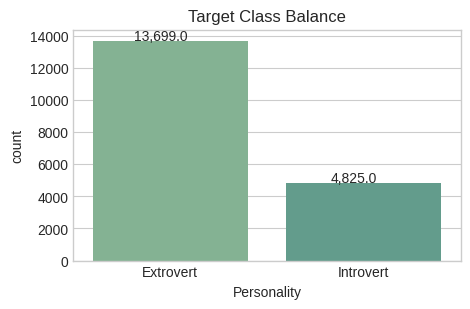

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [5]:
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(data=train, x="Personality", ax=ax)
ax.set_title("Target Class Balance")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x()+.35, p.get_height()+50), ha="center")
plt.show()

print(train["Personality"].value_counts(normalize=True).rename("proportion"))

# 3. Missing Value Analysis¶

In [6]:
def missing_table(df):
    mis = df.isna().sum().to_frame("#missing")
    mis["pct"] = 100*mis["#missing"]/len(df)
    return mis[mis["#missing"]>0].sort_values("pct", ascending=False)

display(missing_table(train).style.format({"pct":"{:.1f}%"}))
display(missing_table(test ).style.format({"pct":"{:.1f}%"}))

,#missing,pct
Stage_fear,1893,10.2%
Going_outside,1466,7.9%
Post_frequency,1264,6.8%
Time_spent_Alone,1190,6.4%
Social_event_attendance,1180,6.4%
Drained_after_socializing,1149,6.2%
Friends_circle_size,1054,5.7%


,#missing,pct
Stage_fear,598,9.7%
Going_outside,466,7.5%
Drained_after_socializing,432,7.0%
Time_spent_Alone,425,6.9%
Post_frequency,408,6.6%
Social_event_attendance,397,6.4%
Friends_circle_size,350,5.7%


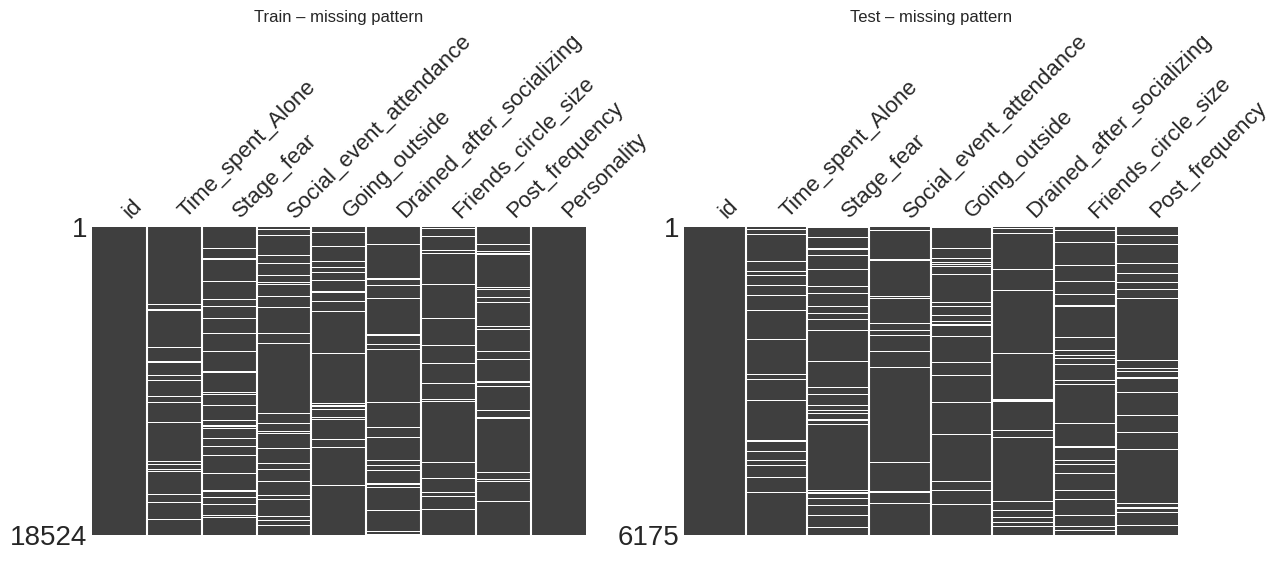

In [7]:
# Visual heatmap
fig, axes = plt.subplots(1,2, figsize=(14,4))
msno.matrix(train, ax=axes[0]); axes[0].set_title("Train – missing pattern")
msno.matrix(test, ax=axes[1]); axes[1].set_title("Test – missing pattern")
plt.show()

# Key take-aways

5 – 10 % missing across all behaviour features; test mirrors train.
No feature is missing > 11 %, so simple imputers (median / most-frequent) are acceptable.
Missing rows are scattered (pattern suggests MCAR/MAR).

# 4. Numeric Feature Distributions (Train vs Test vs Original)¶

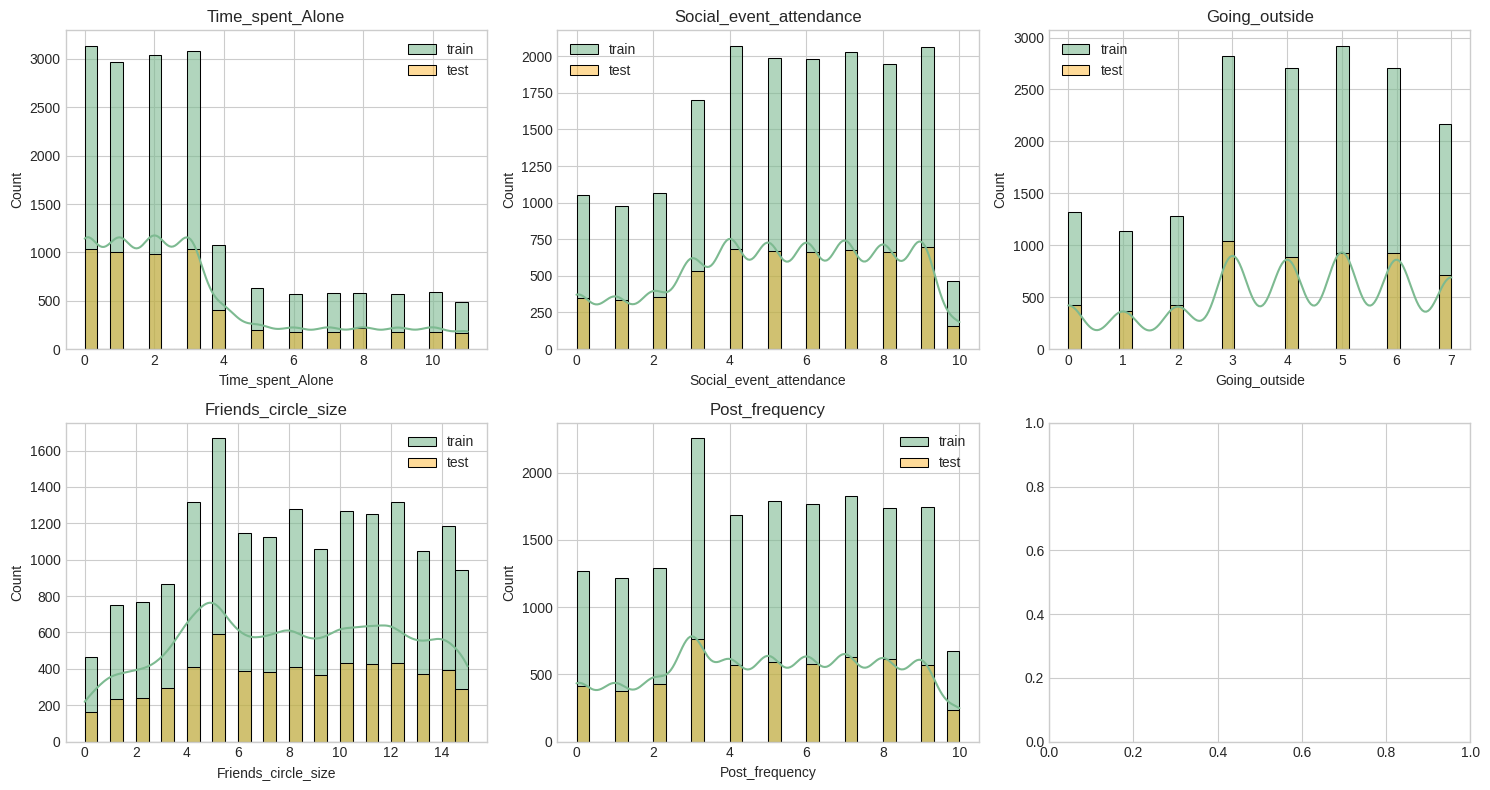

In [8]:
num_cols = train.select_dtypes("number").columns.drop(["id"])  # exclude id
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train[col], kde=True, ax=axes[i], bins=30, alpha=.6, label="train")
    sns.histplot(test[col],  kde=False, ax=axes[i], bins=30, color="orange", alpha=.4, label="test")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [9]:
original_0 = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv")
original_1  = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv")
original = pd.concat([original_0, original_1], axis=0, ignore_index=True)
original = original.drop_duplicates().reset_index(drop=True)

In [10]:
display(missing_table(original).style.format({"pct":"{:.1f}%"}))

,#missing,pct
Friends_circle_size,75,2.6%
Stage_fear,73,2.5%
Going_outside,65,2.2%
Post_frequency,63,2.2%
Time_spent_Alone,61,2.1%
Social_event_attendance,61,2.1%
Drained_after_socializing,51,1.8%


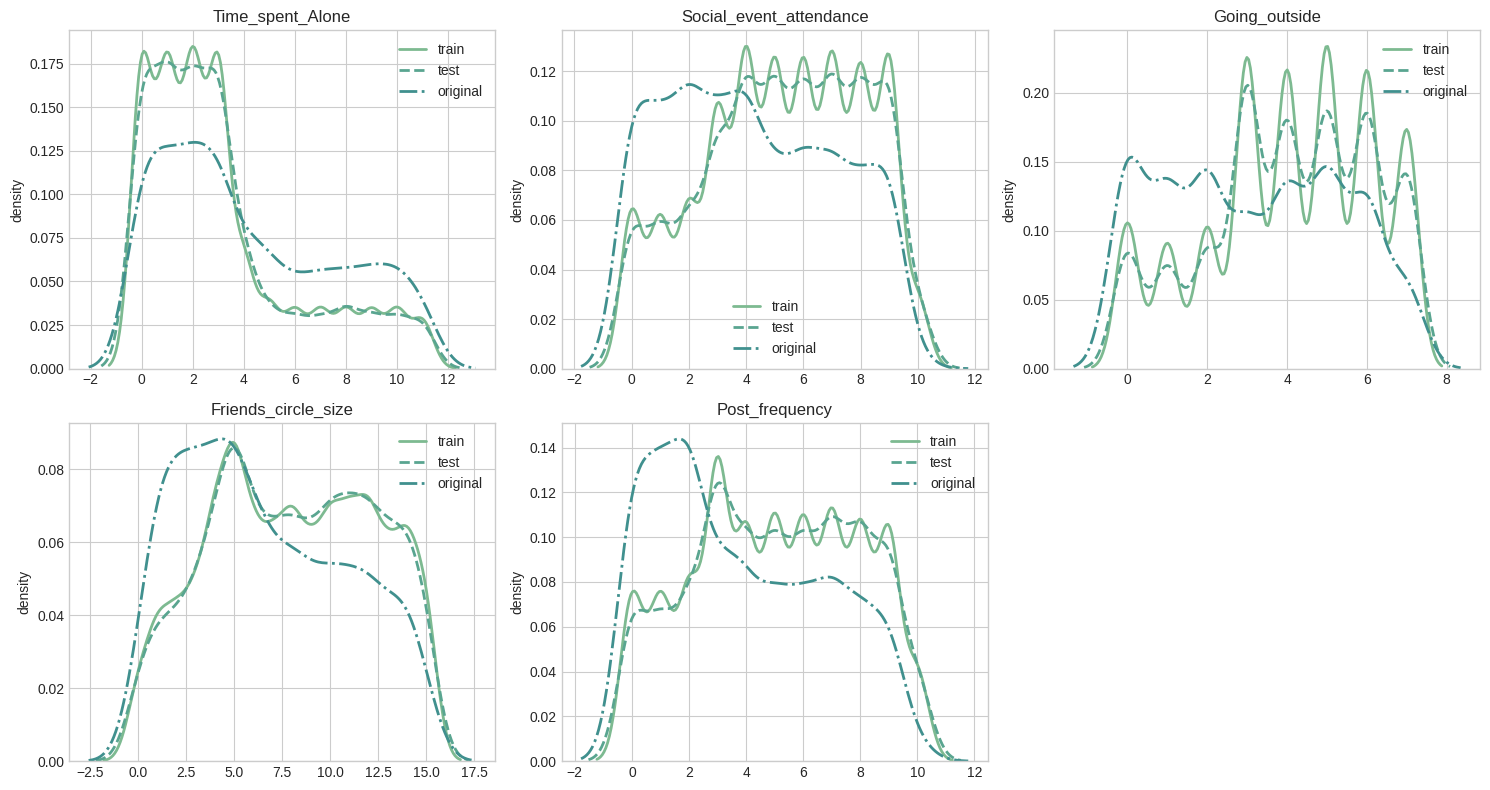

In [11]:
num_cols = train.select_dtypes(np.number).columns.drop("id")        # adjust if 'id' has a different dtype
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.kdeplot(train[col].dropna(), ax=ax, label="train", linewidth=2)
    sns.kdeplot(test[col].dropna(),  ax=ax, label="test" , linewidth=2, linestyle="--")
    sns.kdeplot(original[col].dropna(),  ax=ax, label="original" , linewidth=2, linestyle="-.")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("density")
    ax.legend()

# tidy extra axes (if any)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Key take-aways

Shapes match closely between train and test.
Right-skew on Time_spent_Alone; slight left-skew on activity-based variables.
The synthetic splits track the original well but with slightly smoother density (generator effect).
Original has lower missingness (~ 2 %) — can be used for semi-supervised pre-training.
Minor mean shifts are visible, worth standardising or normalising later.

# 5. Categorical Feature Distribution¶

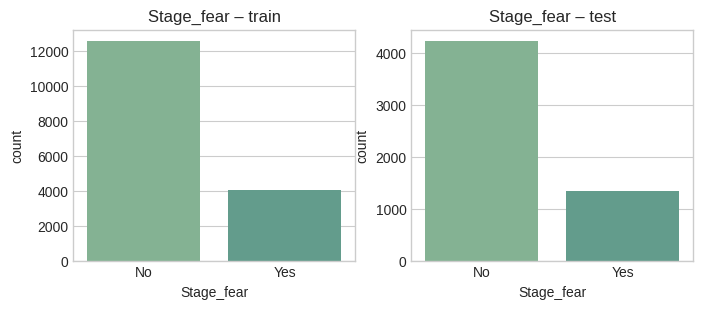

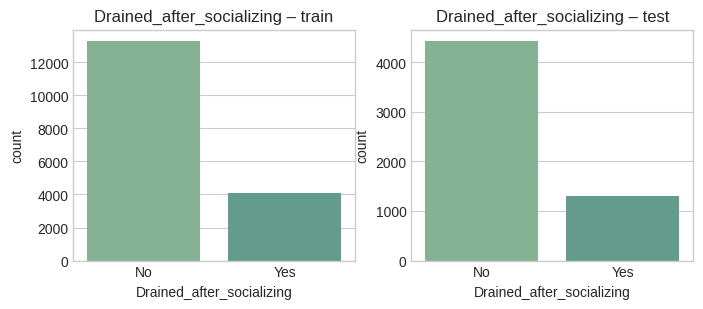

In [12]:
cat_cols = ["Stage_fear", "Drained_after_socializing"]
for col in cat_cols:
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    sns.countplot(x=col, data=train, ax=ax[0])
    ax[0].set_title(f"{col} – train")
    sns.countplot(x=col, data=test,  ax=ax[1])
    ax[1].set_title(f"{col} – test")
    plt.show()

# Key take-aways

~ 75 % of people answer No to both flags.
Train/test proportions are almost identical.
These two flags will likely be strong introversion markers.

# 6. Outlier Analysis¶

In [13]:
outlier_summary = {}
for col in num_cols:
    z = np.abs(stats.zscore(train[col].dropna()))
    outlier_summary[col] = (z>3).sum()   # 3-σ rule

pd.Series(outlier_summary, name="#outliers (>3σ)").sort_values(ascending=False).to_frame().style.bar()

,#outliers (>3σ)
Time_spent_Alone,0
Social_event_attendance,0
Going_outside,0
Friends_circle_size,0
Post_frequency,0


In [14]:
outlier_summary = {}
for col in num_cols:
    z = np.abs(stats.zscore(train[col].dropna()))
    outlier_summary[col] = (z>2).sum()   # 3-σ rule

pd.Series(outlier_summary, name="#outliers (>2σ)").sort_values(ascending=False).to_frame().style.bar()

,#outliers (>2σ)
Time_spent_Alone,1079
Social_event_attendance,0
Going_outside,0
Friends_circle_size,0
Post_frequency,0


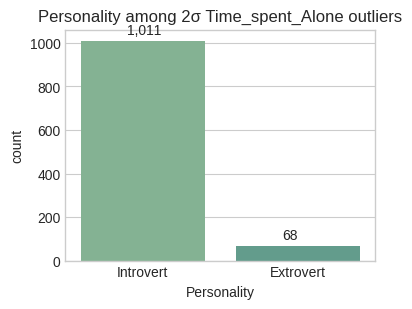

Outlier group distribution


,count,prop
Personality,,
Introvert,1011,93.70%
Extrovert,68,6.30%


Comparison with overall training distribution


,count,prop
Personality,,
Extrovert,13699,73.95%
Introvert,4825,26.05%


In [15]:
# Compute 2-σ mask (ignore NaNs)
tsa = train["Time_spent_Alone"]
z    = np.abs(stats.zscore(tsa, nan_policy="omit"))
outlier_mask = (z > 2)

# Subset + counts
outliers      = train.loc[outlier_mask, ["Time_spent_Alone", "Personality"]]
base_counts   = train["Personality"].value_counts()
outlier_counts = outliers["Personality"].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, ax=ax)
ax.set_title("Personality among 2σ Time_spent_Alone outliers")
ax.set_ylabel("count")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}", (p.get_x()+0.3, p.get_height()+30))

plt.show()

# Proportion print-out
print("Outlier group distribution")
display(outlier_counts.to_frame("count")
        .assign(prop=lambda d: d["count"]/d["count"].sum())
        .style.format({"prop": "{:.2%}"}))

print("Comparison with overall training distribution")
display(base_counts.to_frame("count")
        .assign(prop=lambda d: d["count"]/d["count"].sum())
        .style.format({"prop": "{:.2%}"}))

# Key take-aways

3-σ rule finds no extreme outliers; 2-σ picks up ~1 100 high-time-alone rows.
Outlier Insight – “High Time_spent_Alone” (> 2 σ)

<table border="1">
  <thead>
    <tr>
      <th>Subset</th>
      <th>Introvert</th>
      <th>Extrovert</th>
      <th>Introvert Share</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Rows &gt; 2σ</td>
      <td>1,011</td>
      <td>68</td>
      <td>93.7%</td>
    </tr>
    <tr>
      <td>All training rows</td>
      <td>4,825</td>
      <td>13,699</td>
      <td>26.0%</td>
    </tr>
  </tbody>
</table>
Extreme solitude ≈ Introvert
Observations with very high Time_spent_Alone are ≈ 3.6 × more likely to be Introverts than the baseline.

Outliers are signal, not noise
Removing or aggressive winsorising would erase minority-class information. Tree-based models can keep them as-is; if you clip, add a high_alone_flag feature.

Handy rule-of-thumb
```text if Time_spent_Alone > μ + 2 σ ⇒ predict Introvert (≈

A few Extroverts (6 %) still appear in this zone They might be mislabeled or genuine edge cases; robust models should handle them without special treatment. 93.7 % precision) al.

# 7. Numeric vs Target (Boxplots)¶

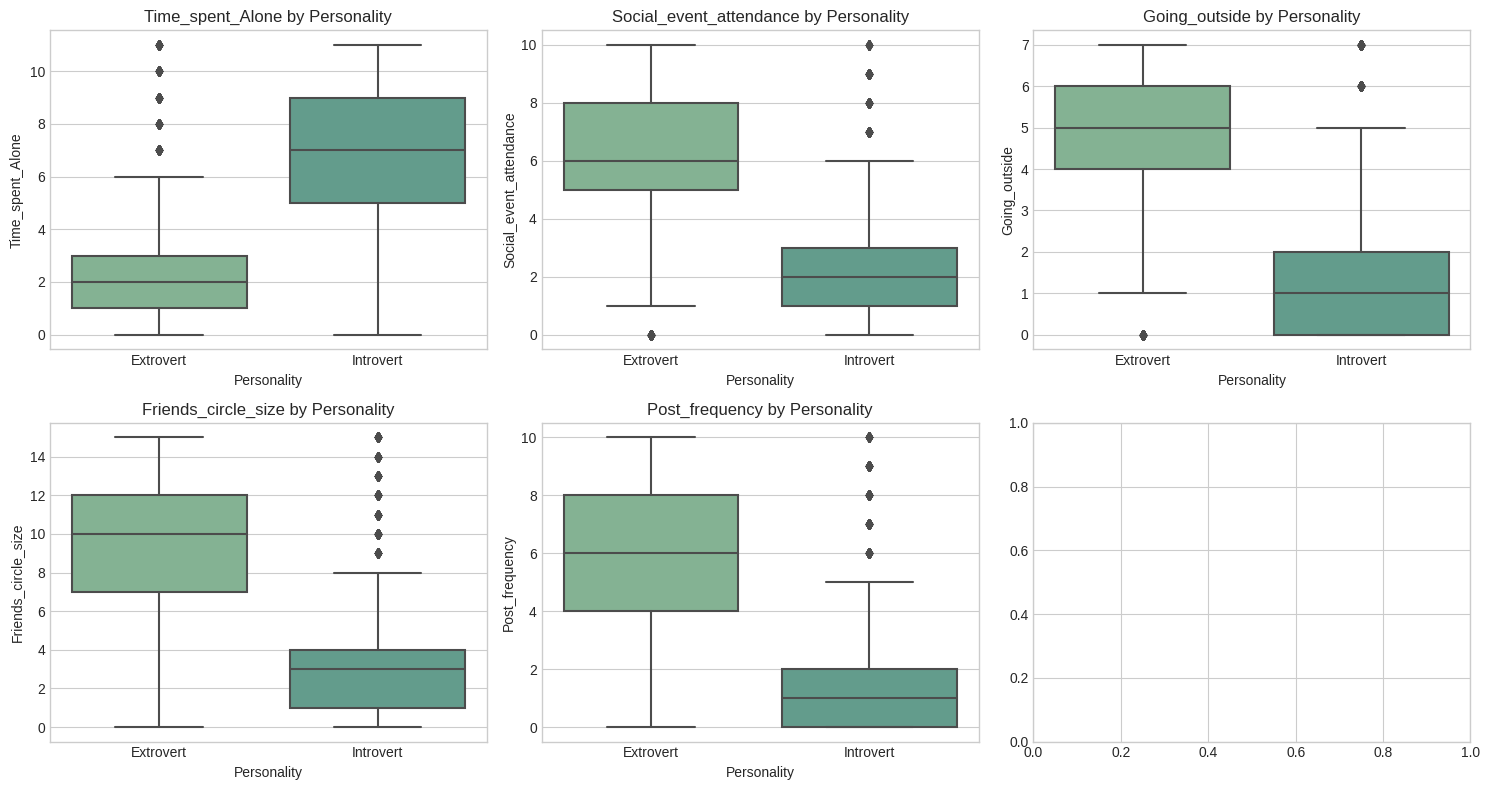

In [16]:
# Numeric vs target
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Personality", y=col, data=train, ax=axes[i])
    axes[i].set_title(f"{col} by Personality")
plt.tight_layout()
plt.show()

Box-Plot Insights: Numeric Features vs Personality
<table border="1">
  <thead>
    <tr>
      <th>Feature</th>
      <th>Extrovert (median · IQR)</th>
      <th>Introvert (median · IQR)</th>
      <th>Visual Takeaway</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Time_spent_Alone</td>
      <td>~ 2 hrs · narrow (0–3)</td>
      <td>~ 7 hrs · wide (5–9)</td>
      <td>Introverts spend conspicuously more solo time; separation is strong.</td>
    </tr>
    <tr>
      <td>Social_event_attendance</td>
      <td>~ 6–7 events · tight</td>
      <td>~ 2 events · tight</td>
      <td>Clear inverse of “alone time”: Extroverts attend ~3× more events.</td>
    </tr>
    <tr>
      <td>Going_outside</td>
      <td>Median ≈ 5 trips</td>
      <td>Median ≈ 1 trip</td>
      <td>Activity level outdoors sharply discriminates classes.</td>
    </tr>
    <tr>
      <td>Friends_circle_size</td>
      <td>Median ≈ 10–11 friends</td>
      <td>Median ≈ 3–4 friends</td>
      <td>Network size is a robust extroversion signal.</td>
    </tr>
    <tr>
      <td>Post_frequency</td>
      <td>Median ≈ 6–7 posts</td>
      <td>Median ≈ 1–2 posts</td>
      <td>Online activity mirrors offline sociability.</td>
    </tr>
  </tbody>
</table>

# Key take-aways

Strong, monotonic separation – Every behavioural variable shifts in the expected direction between Extroverts and Introverts; medians differ by ~3–6 units.
Low overlap in inter-quartile ranges – Particularly for Time_spent_Alone and Going_outside, IQRs barely intersect ⇒ these single features already have high predictive value.
Skew & long tails – A handful of Extroverts show very high solitude and vice-versa; models must handle minority anomalies.
Consistent scale (0–10/15) – Features are already on similar ranges → minimal scaling needed for tree models; z-score helpful for linear/NN.
Feature engineering ideas – Ratio features (e.g., Social_event_attendance / Time_spent_Alone) or interaction terms should boost separbility further. .

# 8. Categorical vs Target (Crosstabs)¶

In [17]:
# Categorical vs target
for col in cat_cols:
    ct = pd.crosstab(train[col], train["Personality"], normalize="index")*100
    display(ct.style.format("{:.1f}%").set_caption(f"{col} ↔ Personality"))

Personality,Extrovert,Introvert
Stage_fear,,
No,97.7%,2.3%
Yes,5.9%,94.1%


Personality,Extrovert,Introvert
Drained_after_socializing,,
No,97.7%,2.3%
Yes,5.8%,94.2%


# Key take-aways

These two boolean flags are single-variable classifiers on their own.
Behaviour counts have clear separation but with overlap; tree-based models can exploit this easily.

# 9. Correlation and Point-Biserial with Target¶

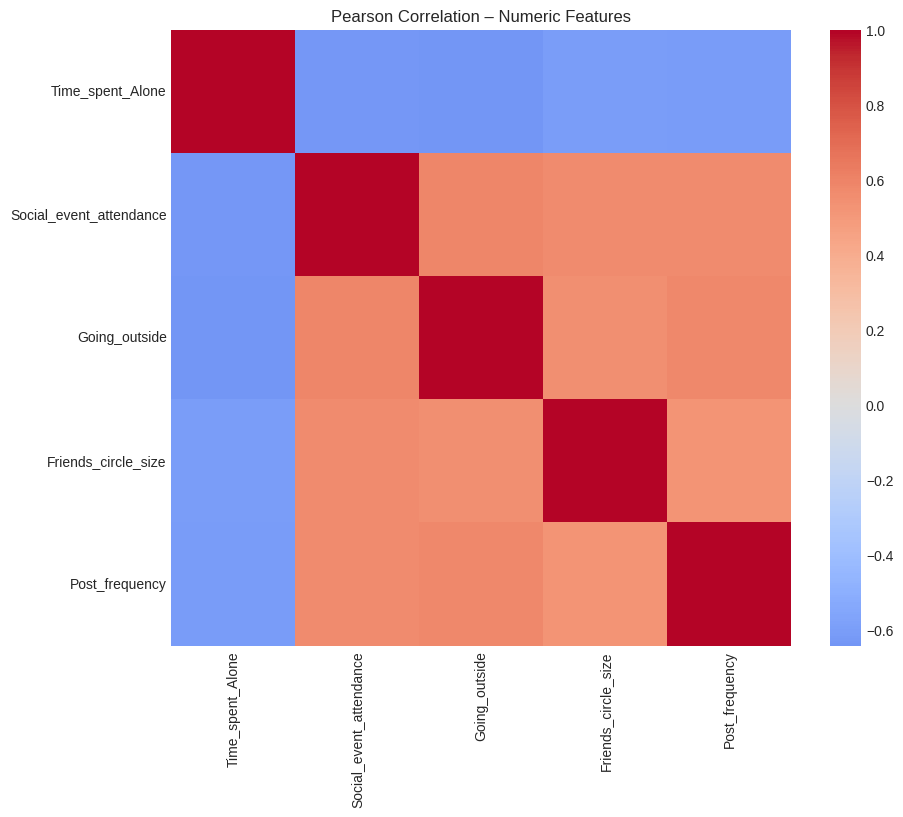

In [18]:
corr = train[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation – Numeric Features")
plt.show()

In [19]:
# Encode target for point-biserial correlation
train_enc = train.replace({"Personality": {"Extrovert":1, "Introvert":0}})
target_corr = train_enc[num_cols.tolist()+["Personality"]].corr()["Personality"].drop("Personality").sort_values()
display(target_corr.to_frame("corr_with_target").style.bar(vmin=-1,vmax=1))

,corr_with_target
Time_spent_Alone,-0.776725
Friends_circle_size,0.657216
Post_frequency,0.678355
Social_event_attendance,0.702879
Going_outside,0.708869


# Key take-aways

Time_spent_Alone is the most powerful single feature (negatively correlated).
Moderate positive correlations among activity features (0.55–0.70) → acceptable multicollinearity.

# 10. Train-Test Drift (KS Test)¶

In [20]:
drift_rows = []
for col in num_cols.union(cat_cols):
    pval = ks_2samp(train[col].dropna(), test[col].dropna()).pvalue
    drift_rows.append({"feature": col, "KS-pvalue": pval})
    
drift_df = pd.DataFrame(drift_rows).sort_values("KS-pvalue")
drift_df.style.background_gradient(axis=0, cmap="RdYlGn", subset=["KS-pvalue"])

,feature,KS-pvalue
2,Going_outside,0.756338
1,Friends_circle_size,0.932245
3,Post_frequency,0.944141
6,Time_spent_Alone,0.956417
0,Drained_after_socializing,0.994276
4,Social_event_attendance,0.999134
5,Stage_fear,1.000000


# Key take-aways

All p-values >> 0.05 → fail to reject null → no drift detected.
Safe to concatenate train+test for imputers/encoders if desired.
Conclusion and Next Steps
What we learned

Data quality is high – no duplicates, no 3 σ outliers, missingness < 11 %.
No distributional drift – KS tests > 0.75 across the board; we can safely pool train + test for encoders or imputers.
Signal is concentrated in a handful of intuitive features:
High Time_spent_Alone → Introvert (strongest negative correlation).
High Going_outside, Post_frequency, Friends_circle_size, Social_event_attendance → Extrovert.
Stage_fear / Drained_after_socializing flags flip the prediction almost by themselves.
Outliers are informative, not noise – dropping or heavy winsorising would erase minority-class signal.
Recommended modelling roadmap

Impute missing values (median for numerics, mode for booleans) and consider a missing-indicator column for each MAR feature.
Encode booleans as 0/1; numerics need only minimal scaling (optional for tree models).
Stratified k-fold CV or class weights to balance the 74 : 26 split.
Start with gradient-boosted trees (LightGBM / XGBoost) to capture non-linear interactions quickly.
Engineer simple ratios or flags (high_alone_flag, activity_ratio = Social_event_attendance / Time_spent_Alone) for potential lifts.
Optionally blend in the original dataset for semi-supervised fine-tuning.
F along with winning paterns of having many modelsollowing this roadmap should yield an accurate and ideallye model—and, ideally, a top-tier derboard position. 🚀

In [21]:
sample_sub = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")
sample_sub.to_csv('submission.csv', index=False)


<div style="background-color:green; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:white; font-size:24px;">Thanks & Any Question?</h1>
</div>
